# Deep Neural Network for MultiClass Classification

## Stage 1: We load the data and required libraries.

For this activity you should use the dataset FashionMNIST, which configures a problem of multiclass clasification (10 classes).

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# MNIST dataset is available in pytorch

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:27<00:00, 960kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 119kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.92MB/s]


In [3]:
# Showing some examples
img, label = training_data[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 9


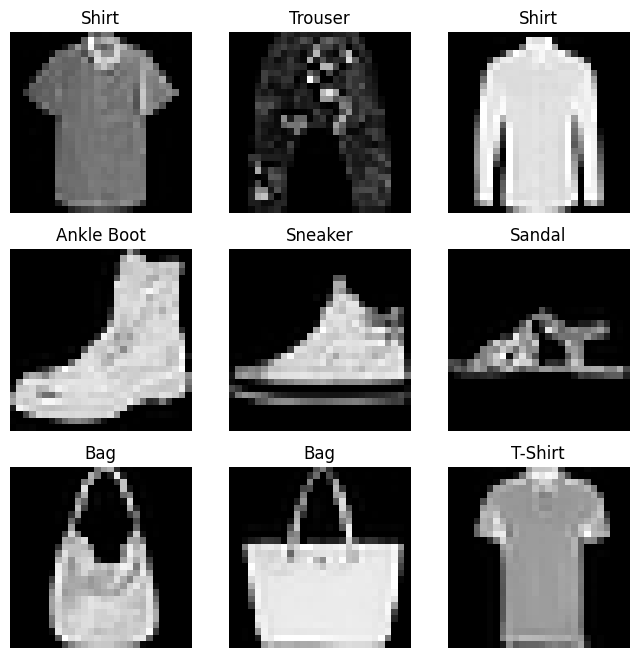

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

You need to solve this dataset, using only fully connected networks, convolutional are not allowed. You must obtain at least an 80% of accuracy over the test set.

In [13]:
# We do this to use the GPU (if we only use CPU, the training will take a lot of time)
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

mps


In [17]:
# We define an object to load the data
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Originally, the inputs were 28x28 images;
        # however, the fully connected networks cannot handle images. Hence, we
        # perform an initial operation called flatten to convert the images into
        # vectors. For example, since we have 28x28 images, the resultant vector
        # will have a dimension of 28*28=784.
        # See https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32), # The input layer has 28*28 units.
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10), # Note that the output layer has 10 units, Also
            # notice that we don't use any activation. This is because the loss
            # function computes the Softmax function internally.
        )

    def forward(self, x):
        # This method is used to compute the output given a particular input x.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
# WE can verify the built network
model = NeuralNetwork()
model.to(device) # This is to define the model in the GPU
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [16]:
# WE define the hyperparameters and the loss function
learning_rate = 0.05
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
# The optimization loop.

loss_tr = []
loss_te = []
for epoch in range(epochs):
  for x, y in train_dataloader:
    # The variable should be sent to the GPU
    x = x.to(device)
    y = y.to(device)
    # Make predictions
    model.train()
    y_pred = model(x)
    # Compute the loss of current predictions
    loss = loss_fn(y_pred, y)
    # Clean the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # update weights
    optimizer.step()
    # Storing the training and test losses
    loss_tr.append(loss.item())
    loss_test = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        loss_test += loss_fn(outputs, labels).item() * labels.size(0)

  loss_te.append(loss_test/len(test_dataloader.dataset))
  print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test/len(test_dataloader.dataset)))

epoch 1 loss: 0.7119 test_loss: 0.7201
epoch 2 loss: 0.5365 test_loss: 0.6339
epoch 3 loss: 0.5099 test_loss: 0.5179
epoch 4 loss: 0.3385 test_loss: 0.4372
epoch 5 loss: 0.6329 test_loss: 0.4420
epoch 6 loss: 0.4902 test_loss: 0.4755
epoch 7 loss: 0.5152 test_loss: 0.4316
epoch 8 loss: 0.2380 test_loss: 0.4234
epoch 9 loss: 0.3400 test_loss: 0.4275
epoch 10 loss: 0.3760 test_loss: 0.4494
epoch 11 loss: 0.1667 test_loss: 0.3910
epoch 12 loss: 0.3267 test_loss: 0.4048
epoch 13 loss: 0.5553 test_loss: 0.4073
epoch 14 loss: 0.4143 test_loss: 0.4521
epoch 15 loss: 0.4906 test_loss: 0.3911
epoch 16 loss: 0.3402 test_loss: 0.3718
epoch 17 loss: 0.1331 test_loss: 0.4015
epoch 18 loss: 0.3873 test_loss: 0.3964
epoch 19 loss: 0.4112 test_loss: 0.3666
epoch 20 loss: 0.3207 test_loss: 0.3873


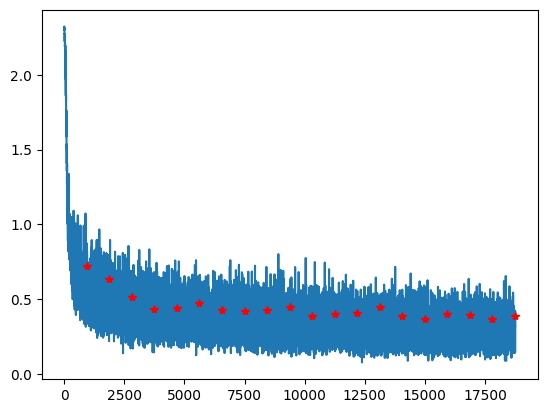

In [19]:
# Plot the losses for the train and test sets
import numpy as np
plt.plot(loss_tr)
plt.plot(np.arange(1,21)*len(train_dataloader.dataset)//64,loss_te, 'r*')
plt.show()

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 86 %
